# Случайный лес (Random Forest)

Случайный лес — это ансамблевый алгоритм машинного обучения, который строит множество решающих деревьев и объединяет их предсказания для получения более точного и стабильного результата. Основная идея — комбинирование "слабых" моделей (деревьев) в "сильную" модель за счет снижения переобучения и дисперсии.

## Алгоритм обучения

1. Для t = 1 до n_estimators:
   1. Создать бутстрап выборку D_t из исходных данных D
   2. Построить решающее дерево T_t на выборке D_t:
        - На каждом узле:
          1) Случайно выбрать подмножество признаков F_t ⊆ F
          2) Найти наилучшее разбиение среди признаков F_t
          3) Разделить узел на два дочерних
        - Продолжать до выполнения критериев остановки
   3. Сохранить дерево T_t в ансамбль

2. Вернуть ансамбль деревьев {T_1, T_2, ..., T_n}

## Алгоритм предсказания

Для каждого объекта x и для каждого дерева T_t в лесу необходимо получить предсказание p_t(x)

1. Для классификации:
   Вернуть наиболее частый класс (голосование)
2. Для регрессии:
   Вернуть среднее значение предсказаний

## Дерево решения

In [687]:
import numpy as np

In [688]:
from typing import Optional, Union, Tuple, Callable

In [689]:
class Leaf:

    def __init__(self, labels):
        self.prediction = np.argmax(np.bincount(labels))


    def predict(self, _: np.float64) -> np.float64:
        return self.prediction

In [690]:
class Node:

    def __init__(self,
                 index: int,
                 threshold: np.float64,
                 true_branch: Union["Node", Leaf],
                 false_branch: Union["Node", Leaf]):
        self.index = index
        self.threshold = threshold

        self.true_branch = true_branch
        self.false_branch = false_branch


    def predict(self, x: np.float64) -> np.float64:
        return (self.true_branch if x[self.index] <= self.threshold else self.false_branch).predict(x)

In [691]:
class DecisionTree:
    def __init__(self,
                 max_depth: Optional[int] = None,
                 min_samples_leaf: int = 1,
                 selection_rule: Optional[Union[int, str, float]] = None,
                 random_state: Optional[int] = None):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.selection_rule = selection_rule
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state) if random_state is not None else np.random
        self.tree = None

    def stop_condition(self, y: np.ndarray, depth: int) -> bool:
        return (
            (self.max_depth is not None and depth >= self.max_depth) or
            (len(y) < 2 * self.min_samples_leaf) or
            (len(np.unique(y)) == 1)
        )

    @staticmethod
    def _gini_impurity(y: np.ndarray) -> float:
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _select_features(self, n_features: int) -> np.ndarray:
        if self.selection_rule is None:
            return np.arange(n_features)

        if isinstance(self.selection_rule, str):
            if self.selection_rule == "sqrt":
                n_select = int(np.sqrt(n_features))
            elif self.selection_rule == "log":
                n_select = int(np.log2(n_features)) + 1
            else:
                n_select = n_features
        elif isinstance(self.selection_rule, float):
            n_select = int(self.selection_rule * n_features)
        elif isinstance(self.selection_rule, int):
            n_select = self.selection_rule
        else:
            n_select = n_features

        n_select = max(1, min(n_select, n_features))
        return self.rng.choice(n_features, size=n_select, replace=False)

    def best_split(self, X: np.ndarray, y: np.ndarray) -> Optional[Tuple[int, np.float64, Tuple[np.ndarray, np.ndarray]]]:
        best_gini_gain = -1
        best_feature_index = None
        best_threshold = None
        best_split = None

        feature_indices = self._select_features(X.shape[1])

        for feature_index in feature_indices:
            feature_values = np.unique(X[:, feature_index])

            if len(feature_values) <= 1:
                continue

            for i in range(len(feature_values) - 1):
                threshold = (feature_values[i] + feature_values[i + 1]) / 2

                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                y_left = y[left_mask]
                y_right = y[right_mask]

                if (len(y_left) < self.min_samples_leaf or
                    len(y_right) < self.min_samples_leaf):
                    continue

                parent_gini = DecisionTree._gini_impurity(y)
                left_gini = DecisionTree._gini_impurity(y_left)
                right_gini = DecisionTree._gini_impurity(y_right)

                weighted_gini = (len(y_left) / len(y)) * left_gini + (len(y_right) / len(y)) * right_gini
                gini_gain = parent_gini - weighted_gini

                if gini_gain > best_gini_gain:
                    best_gini_gain = gini_gain
                    best_feature_index = feature_index
                    best_threshold = threshold
                    best_split = (left_mask, right_mask)

        return ((best_feature_index, best_threshold, best_split)
                if best_split is not None else None)

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> Union[Node, Leaf]:
        if self.stop_condition(y, depth):
            return Leaf(y)

        split = self.best_split(X, y)
        if split is None:
            return Leaf(y)

        feature_index, threshold, (left_mask, right_mask) = split

        return Node(
            index=feature_index,
            threshold=threshold,
            true_branch=self._build_tree(
                X[left_mask], y[left_mask], depth + 1
            ),
            false_branch=self._build_tree(
                X[right_mask], y[right_mask], depth + 1
            )
        )

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.tree = self._build_tree(X, y, 1)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.tree is None:
            raise ValueError("Дерево не обучено.")
        return np.array([self.tree.predict(x) for x in X])

## Случайный лес

In [692]:
class RandomForest:
    def __init__(self,
                 n_estimators: int = 50,
                 max_depth: Optional[int] = None,
                 min_samples_leaf: int = 1,
                 selection_rule: Optional[Union[int, str, float]] = "sqrt",
                 random_state: Optional[int] = None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.selection_rule = selection_rule
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state) if random_state is not None else np.random
        self.trees = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples = X.shape[0]
        self.trees = []

        for i in range(self.n_estimators):
            indices = self.rng.choice(n_samples, n_samples, replace=True)
            X_bootstrapped, y_bootstrapped = X[indices], y[indices]

            tree_seed = self.rng.randint(0, 2**31 - 1)

            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                selection_rule=self.selection_rule,
                random_state=tree_seed
            )
            tree.fit(X_bootstrapped, y_bootstrapped)

            self.trees.append(tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if not self.trees:
            raise ValueError("Лес не обучен.")
        return np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x.astype(int))),
            axis=0,
            arr=np.array([tree.predict(X) for tree in self.trees])
        )

# Тестирование модели

In [693]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection

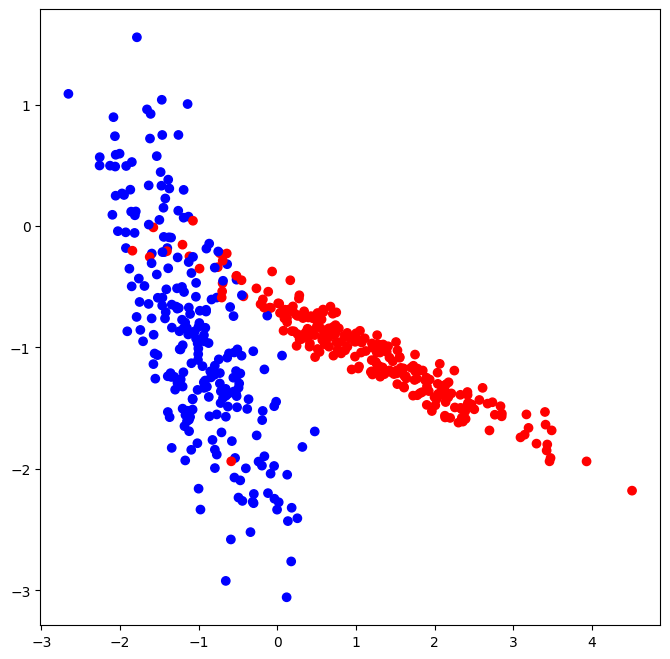

In [694]:
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1,
                                                      random_state=23)

colors = ListedColormap(["red", "blue"])
light_colors = ListedColormap(["lightcoral", "lightblue"])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), c=classification_labels, cmap=colors)

In [695]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size = 0.3,
                                                                                    random_state=1)

In [696]:
model = RandomForest(50, 10)
model.fit(train_data, train_labels)

In [697]:
train_predictions = model.predict(train_data)
test_predictions = model.predict(test_data)


def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


train_accuracy = accuracy_metric(train_labels, train_predictions)
print(train_accuracy)

test_accuracy = accuracy_metric(test_labels, test_predictions)
print(test_accuracy)

100.0
93.33333333333333


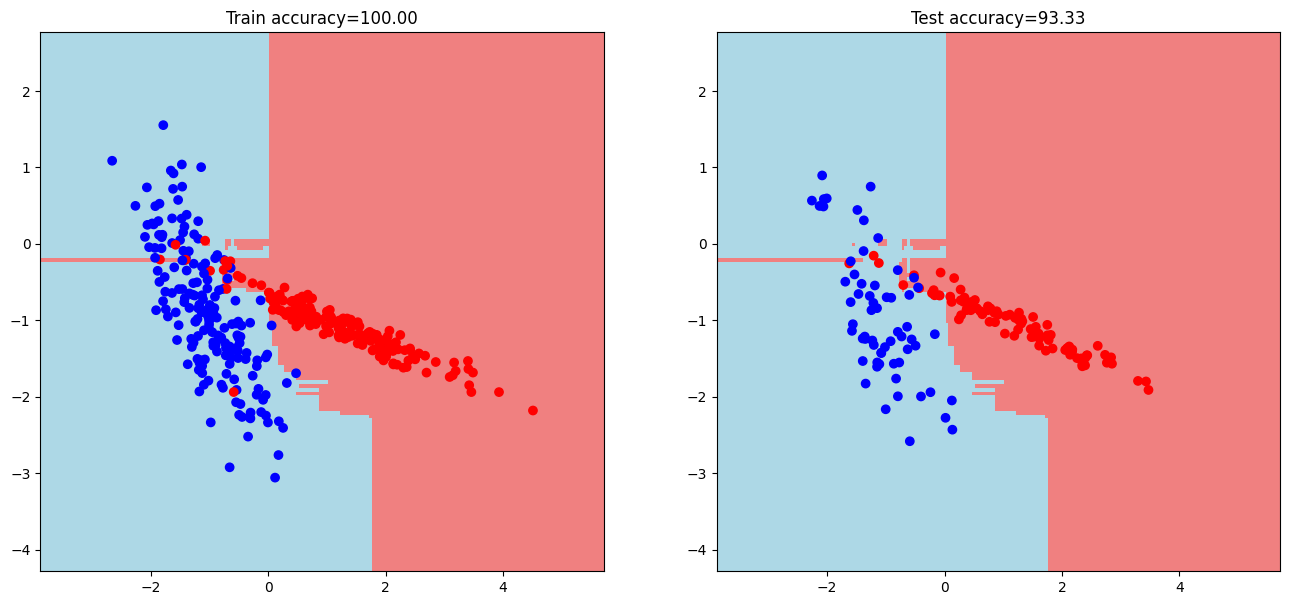

In [698]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()